In [1]:
pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 11.1 MB/s eta 0:00:00


In [2]:
from google.colab.patches import cv2_imshow

In [3]:
import fitz  # PyMuPDF
from PIL import Image

def convert_pdfs_to_images(pdf_paths, output_path):
    for idx, pdf_path in enumerate(pdf_paths, start=1):
        # Open the PDF file
        pdf_document = fitz.open(pdf_path)

        # Iterate through each page
        for page_number in range(pdf_document.page_count):
            # Get the page
            page = pdf_document[page_number]

            # Convert the page to a pixmap
            pixmap = page.get_pixmap()

            # Convert the pixmap to a PIL Image
            image = Image.frombytes("RGB", [pixmap.width, pixmap.height], pixmap.samples)

            # Save the image with the appropriate name
            image.save(f"{output_path}/im{idx}_page_{page_number + 1}.png")

        # Close the PDF file
        pdf_document.close()

# Example usage with two PDFs
pdf_file_paths = ['/content/IG-10309-DA-0000-09-LY-00002_A.pdf', '/content/IG-10309-DA-0000-09-LY-00002_B.pdf']
output_folder_path = '/content'

convert_pdfs_to_images(pdf_file_paths, output_folder_path)


Image Similarity: 99.9543%


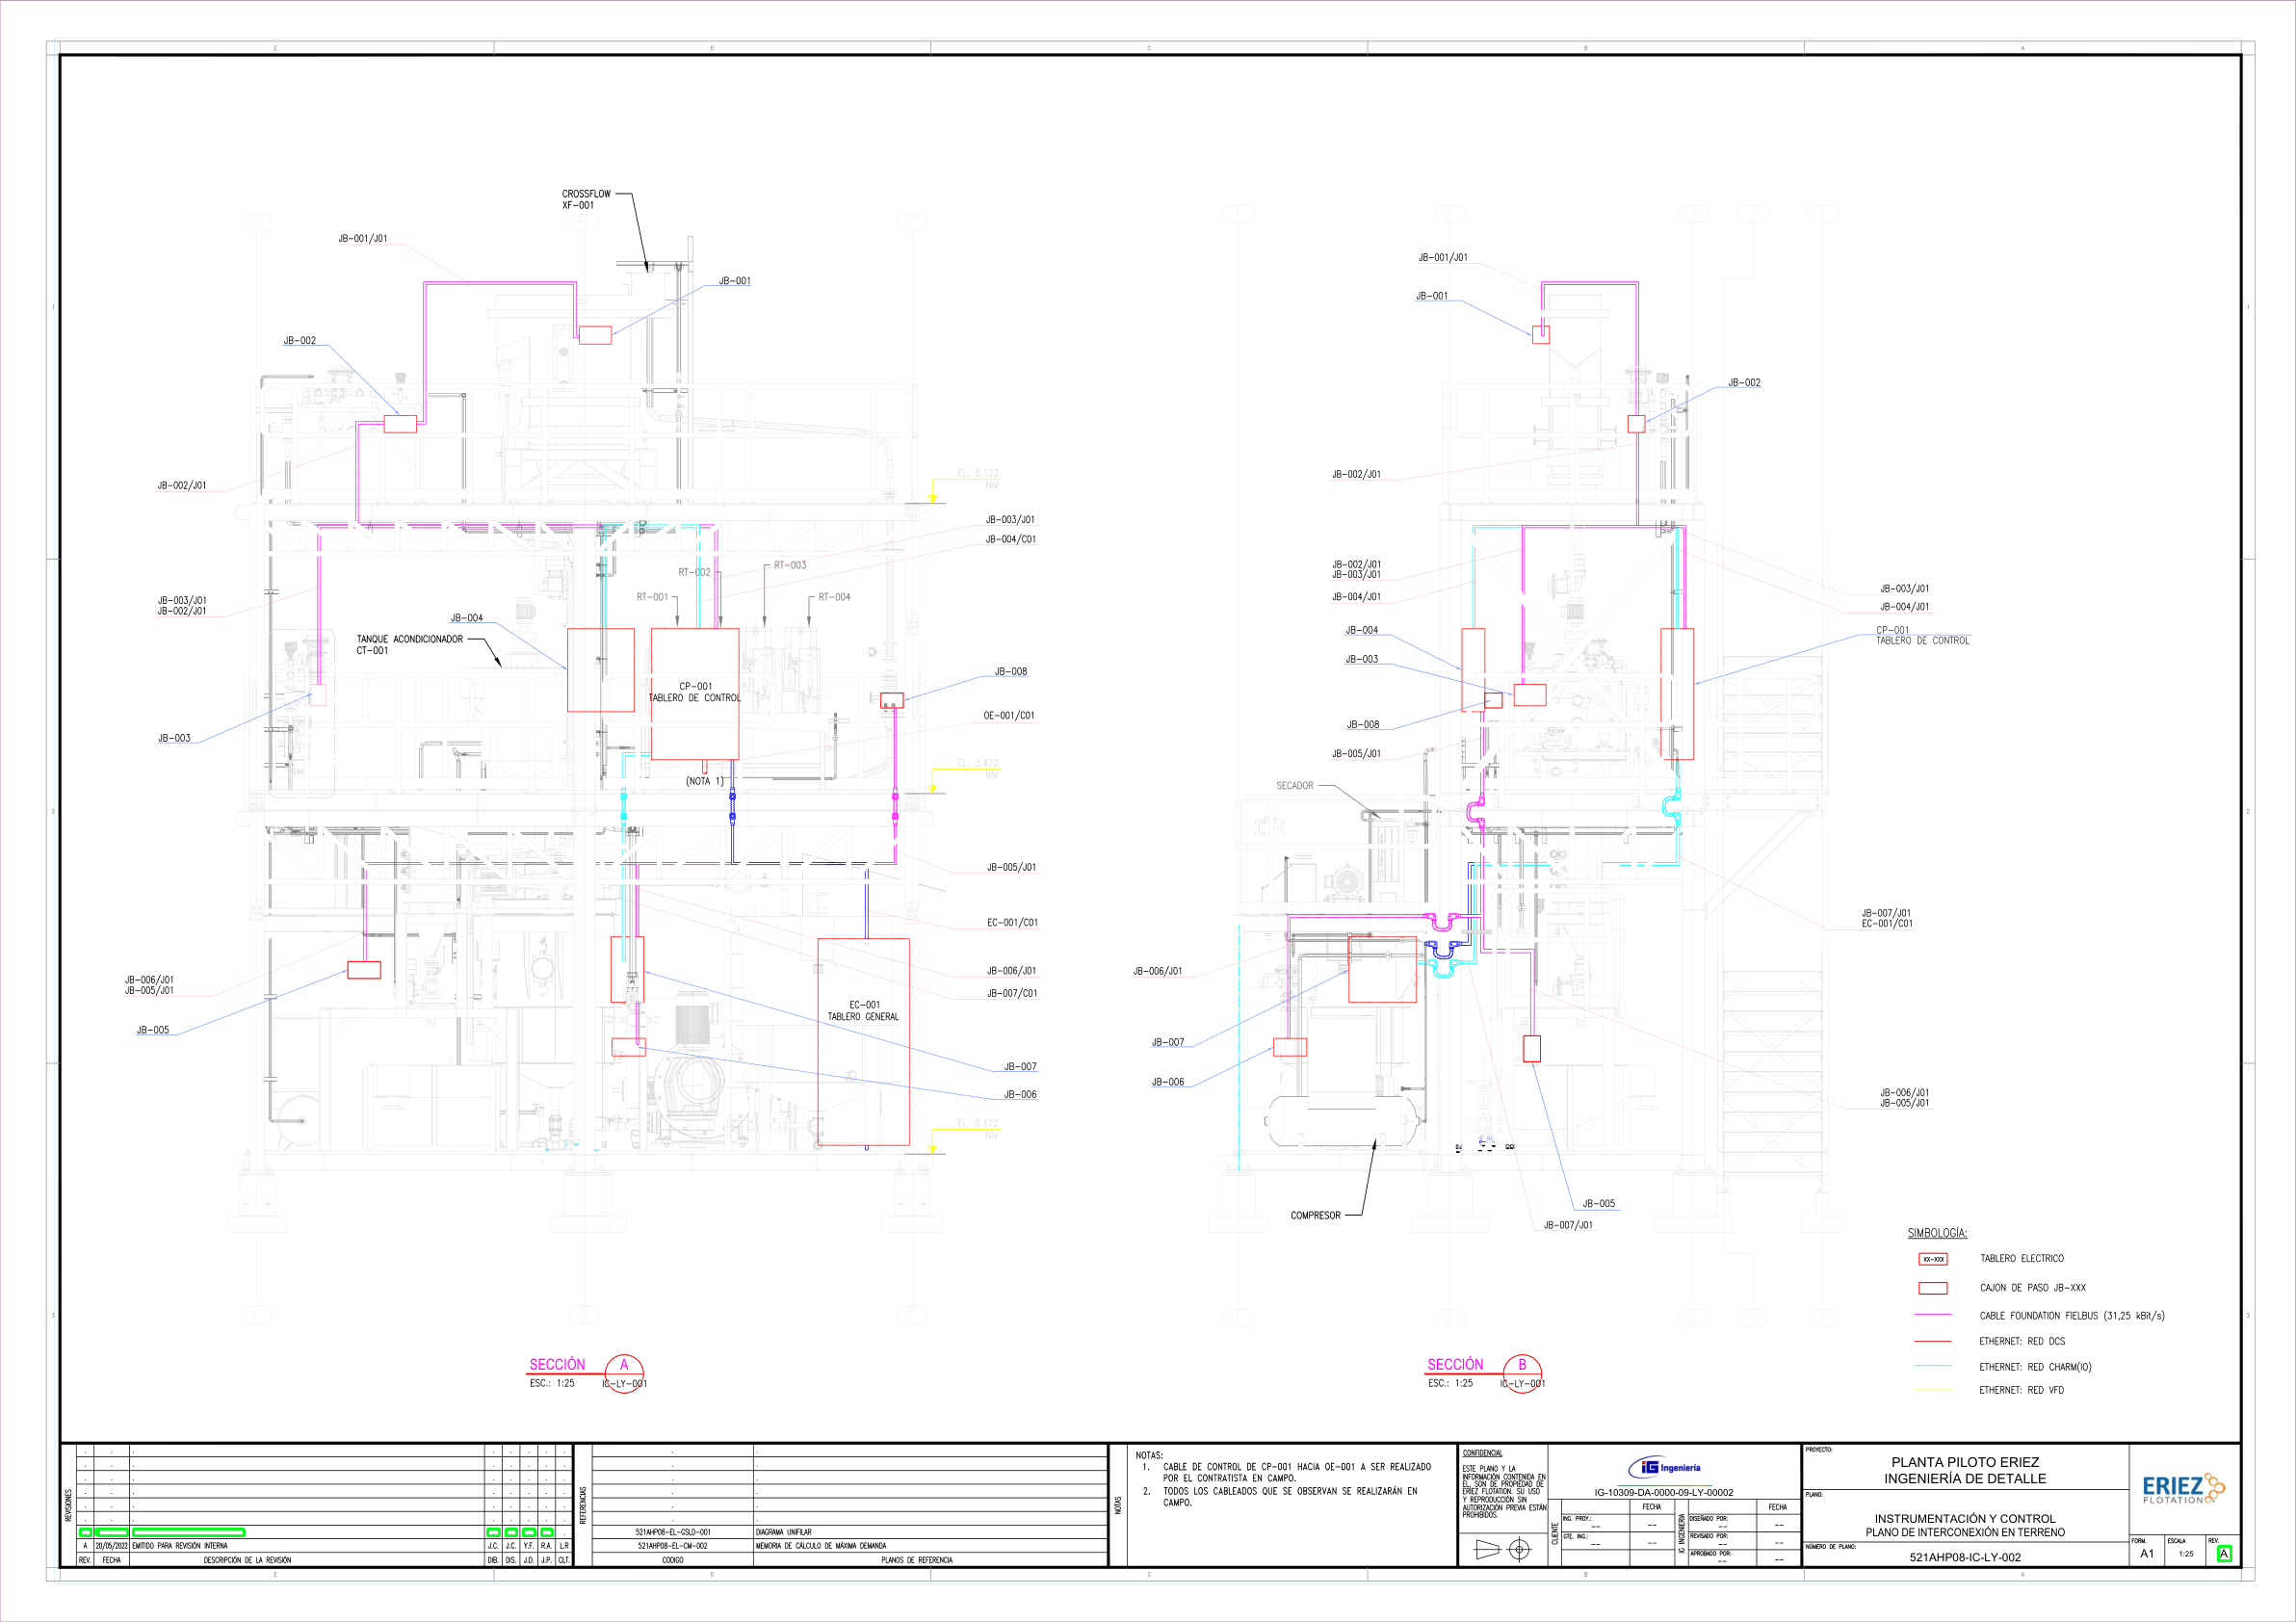

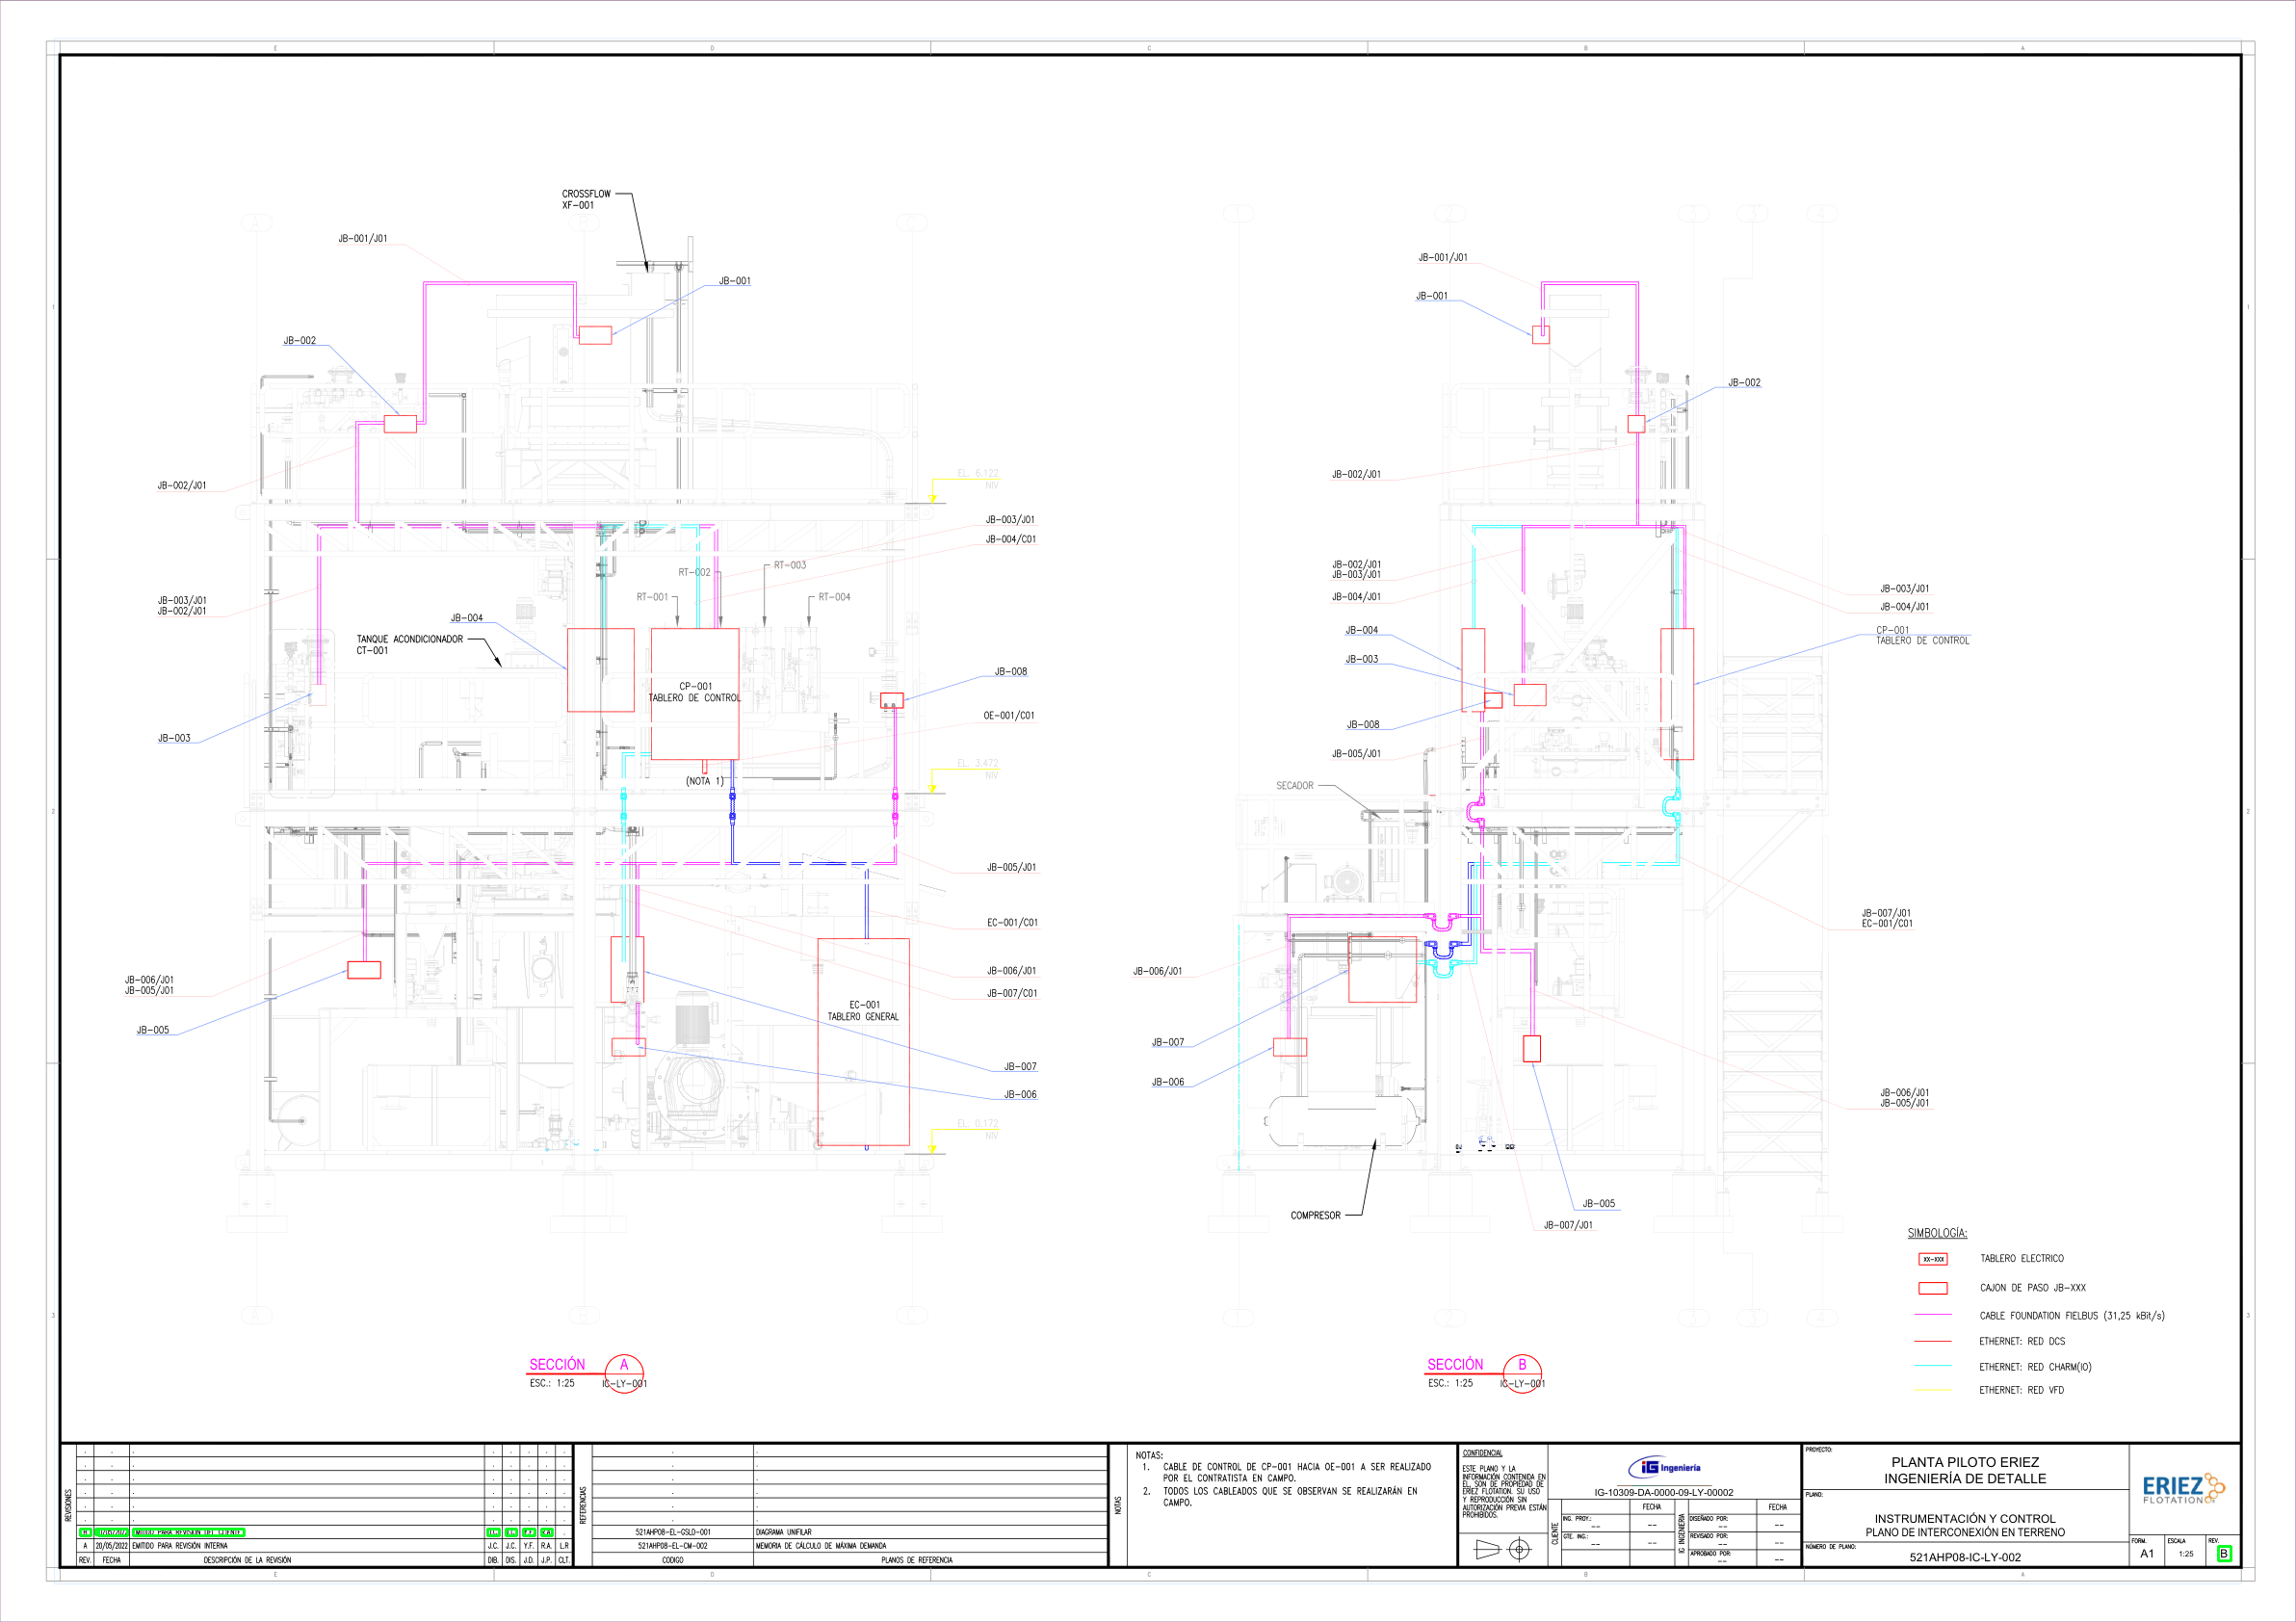

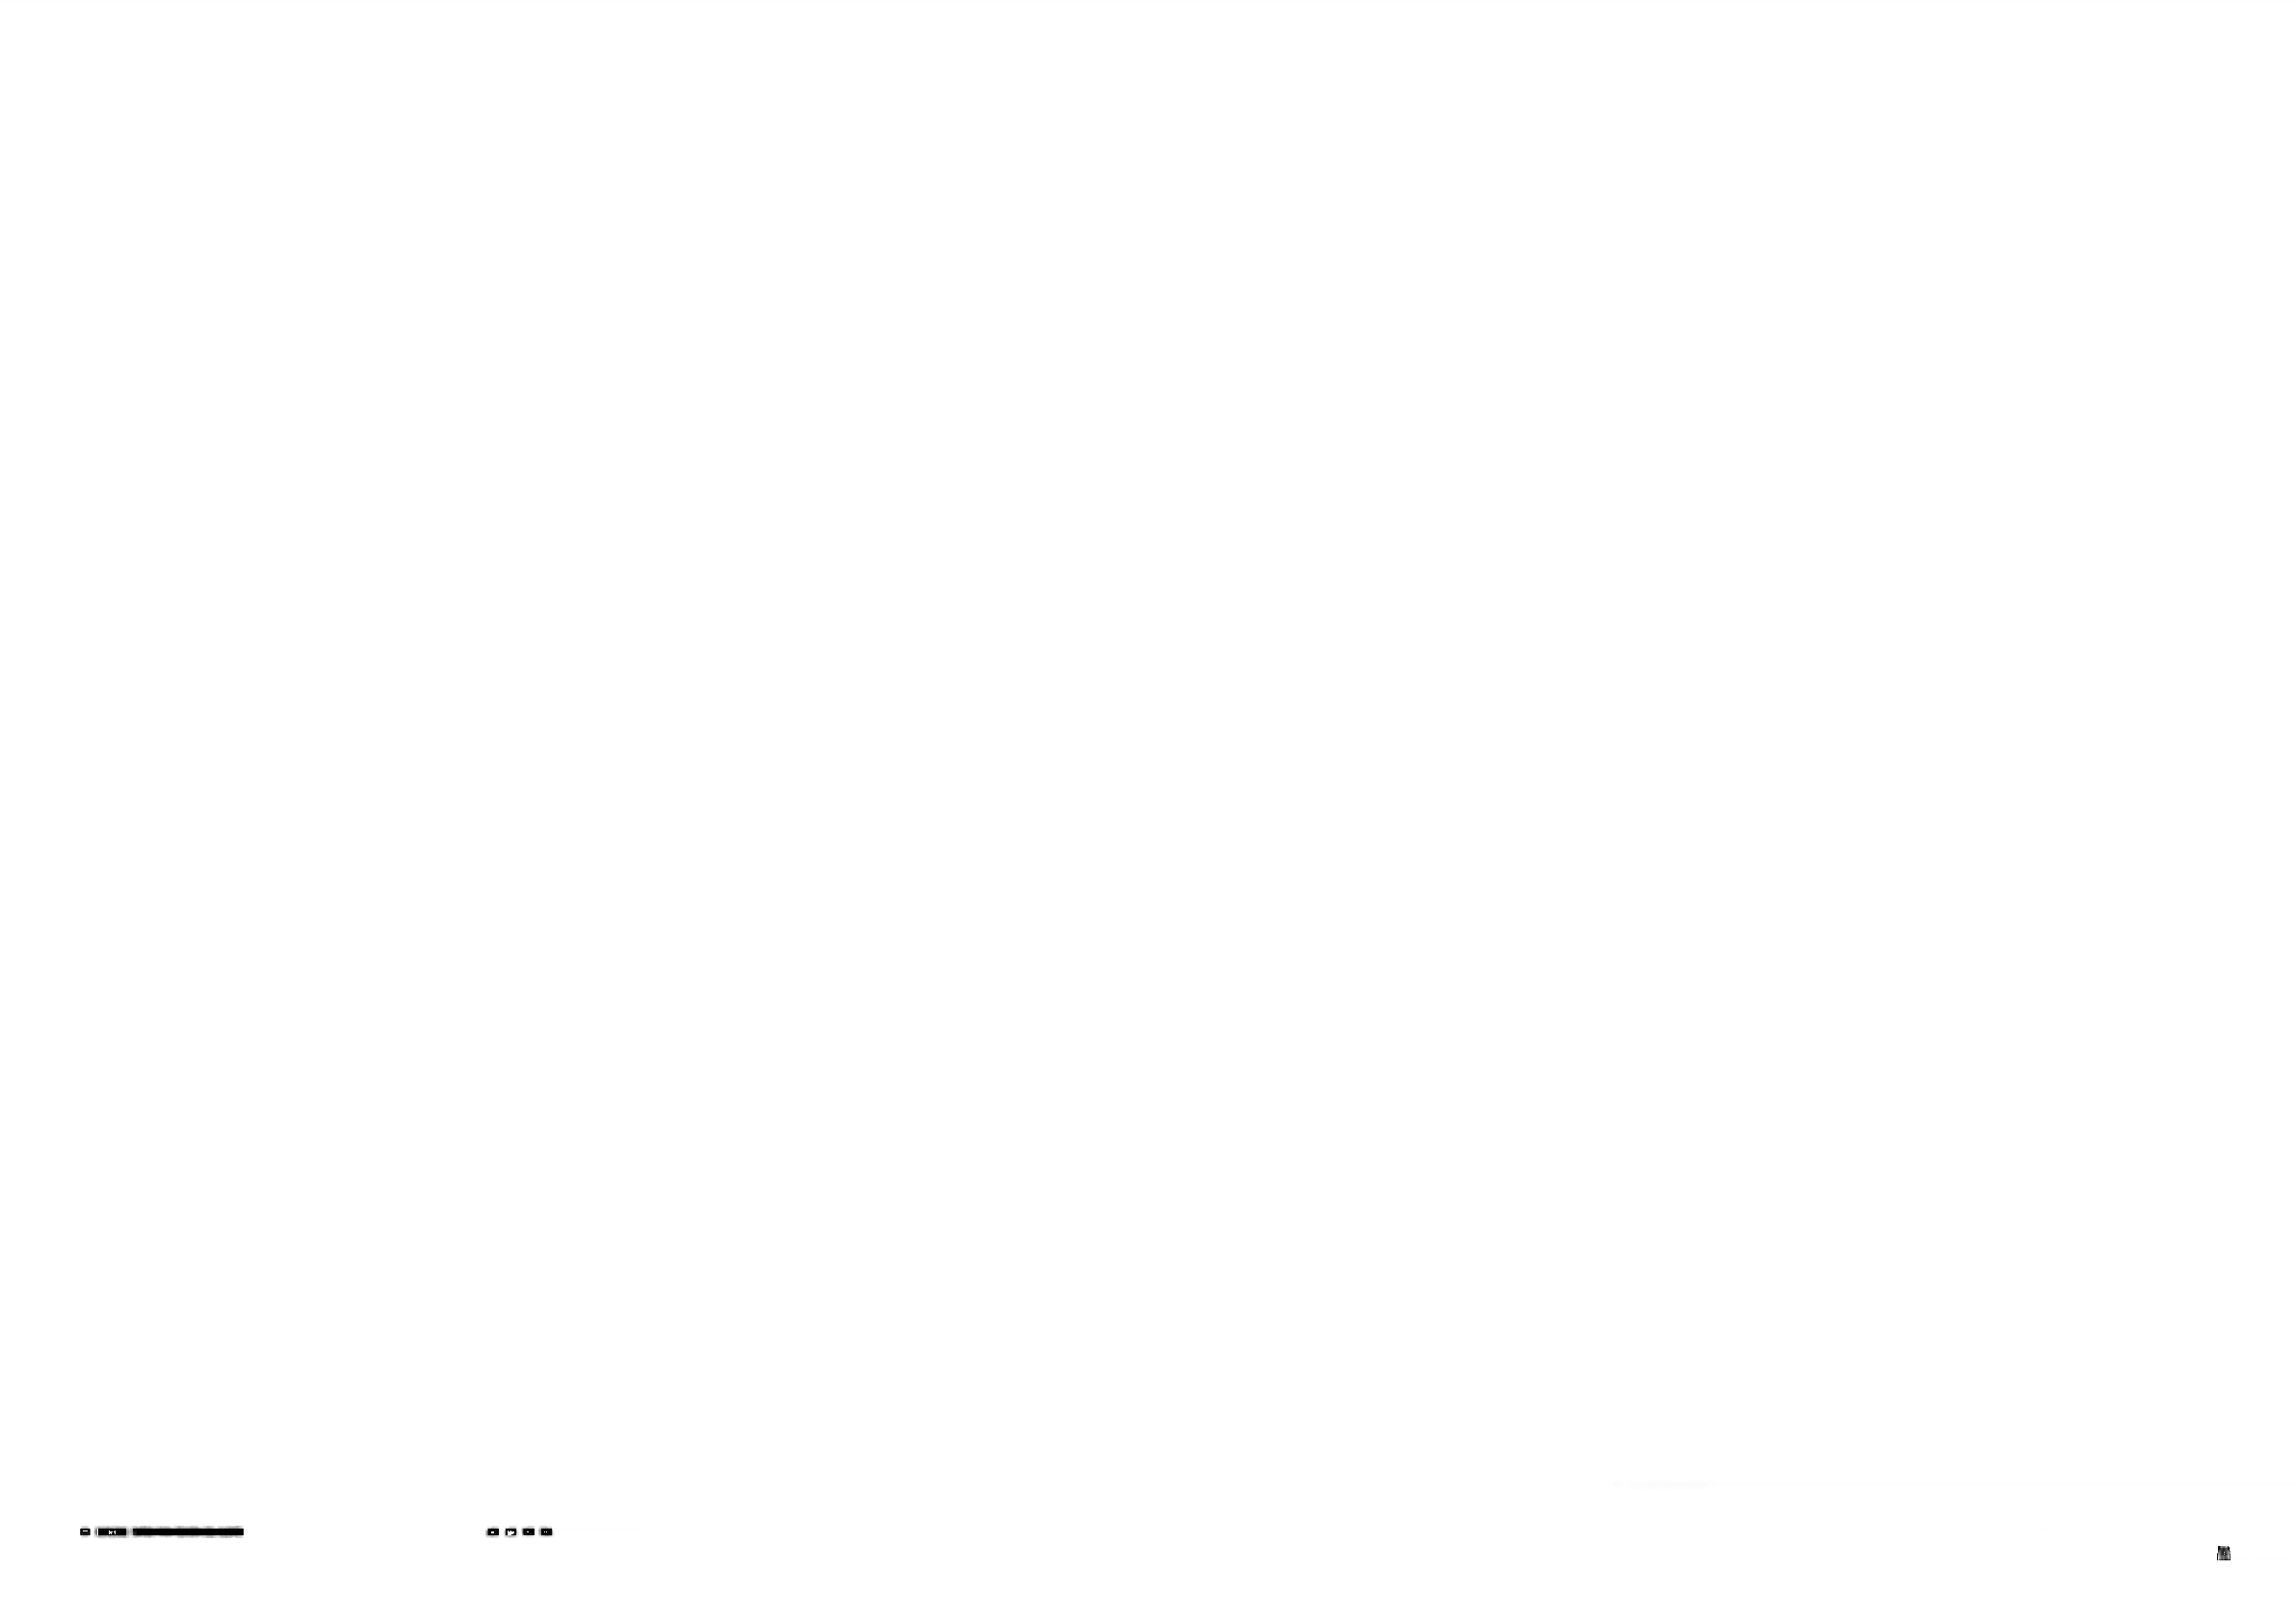

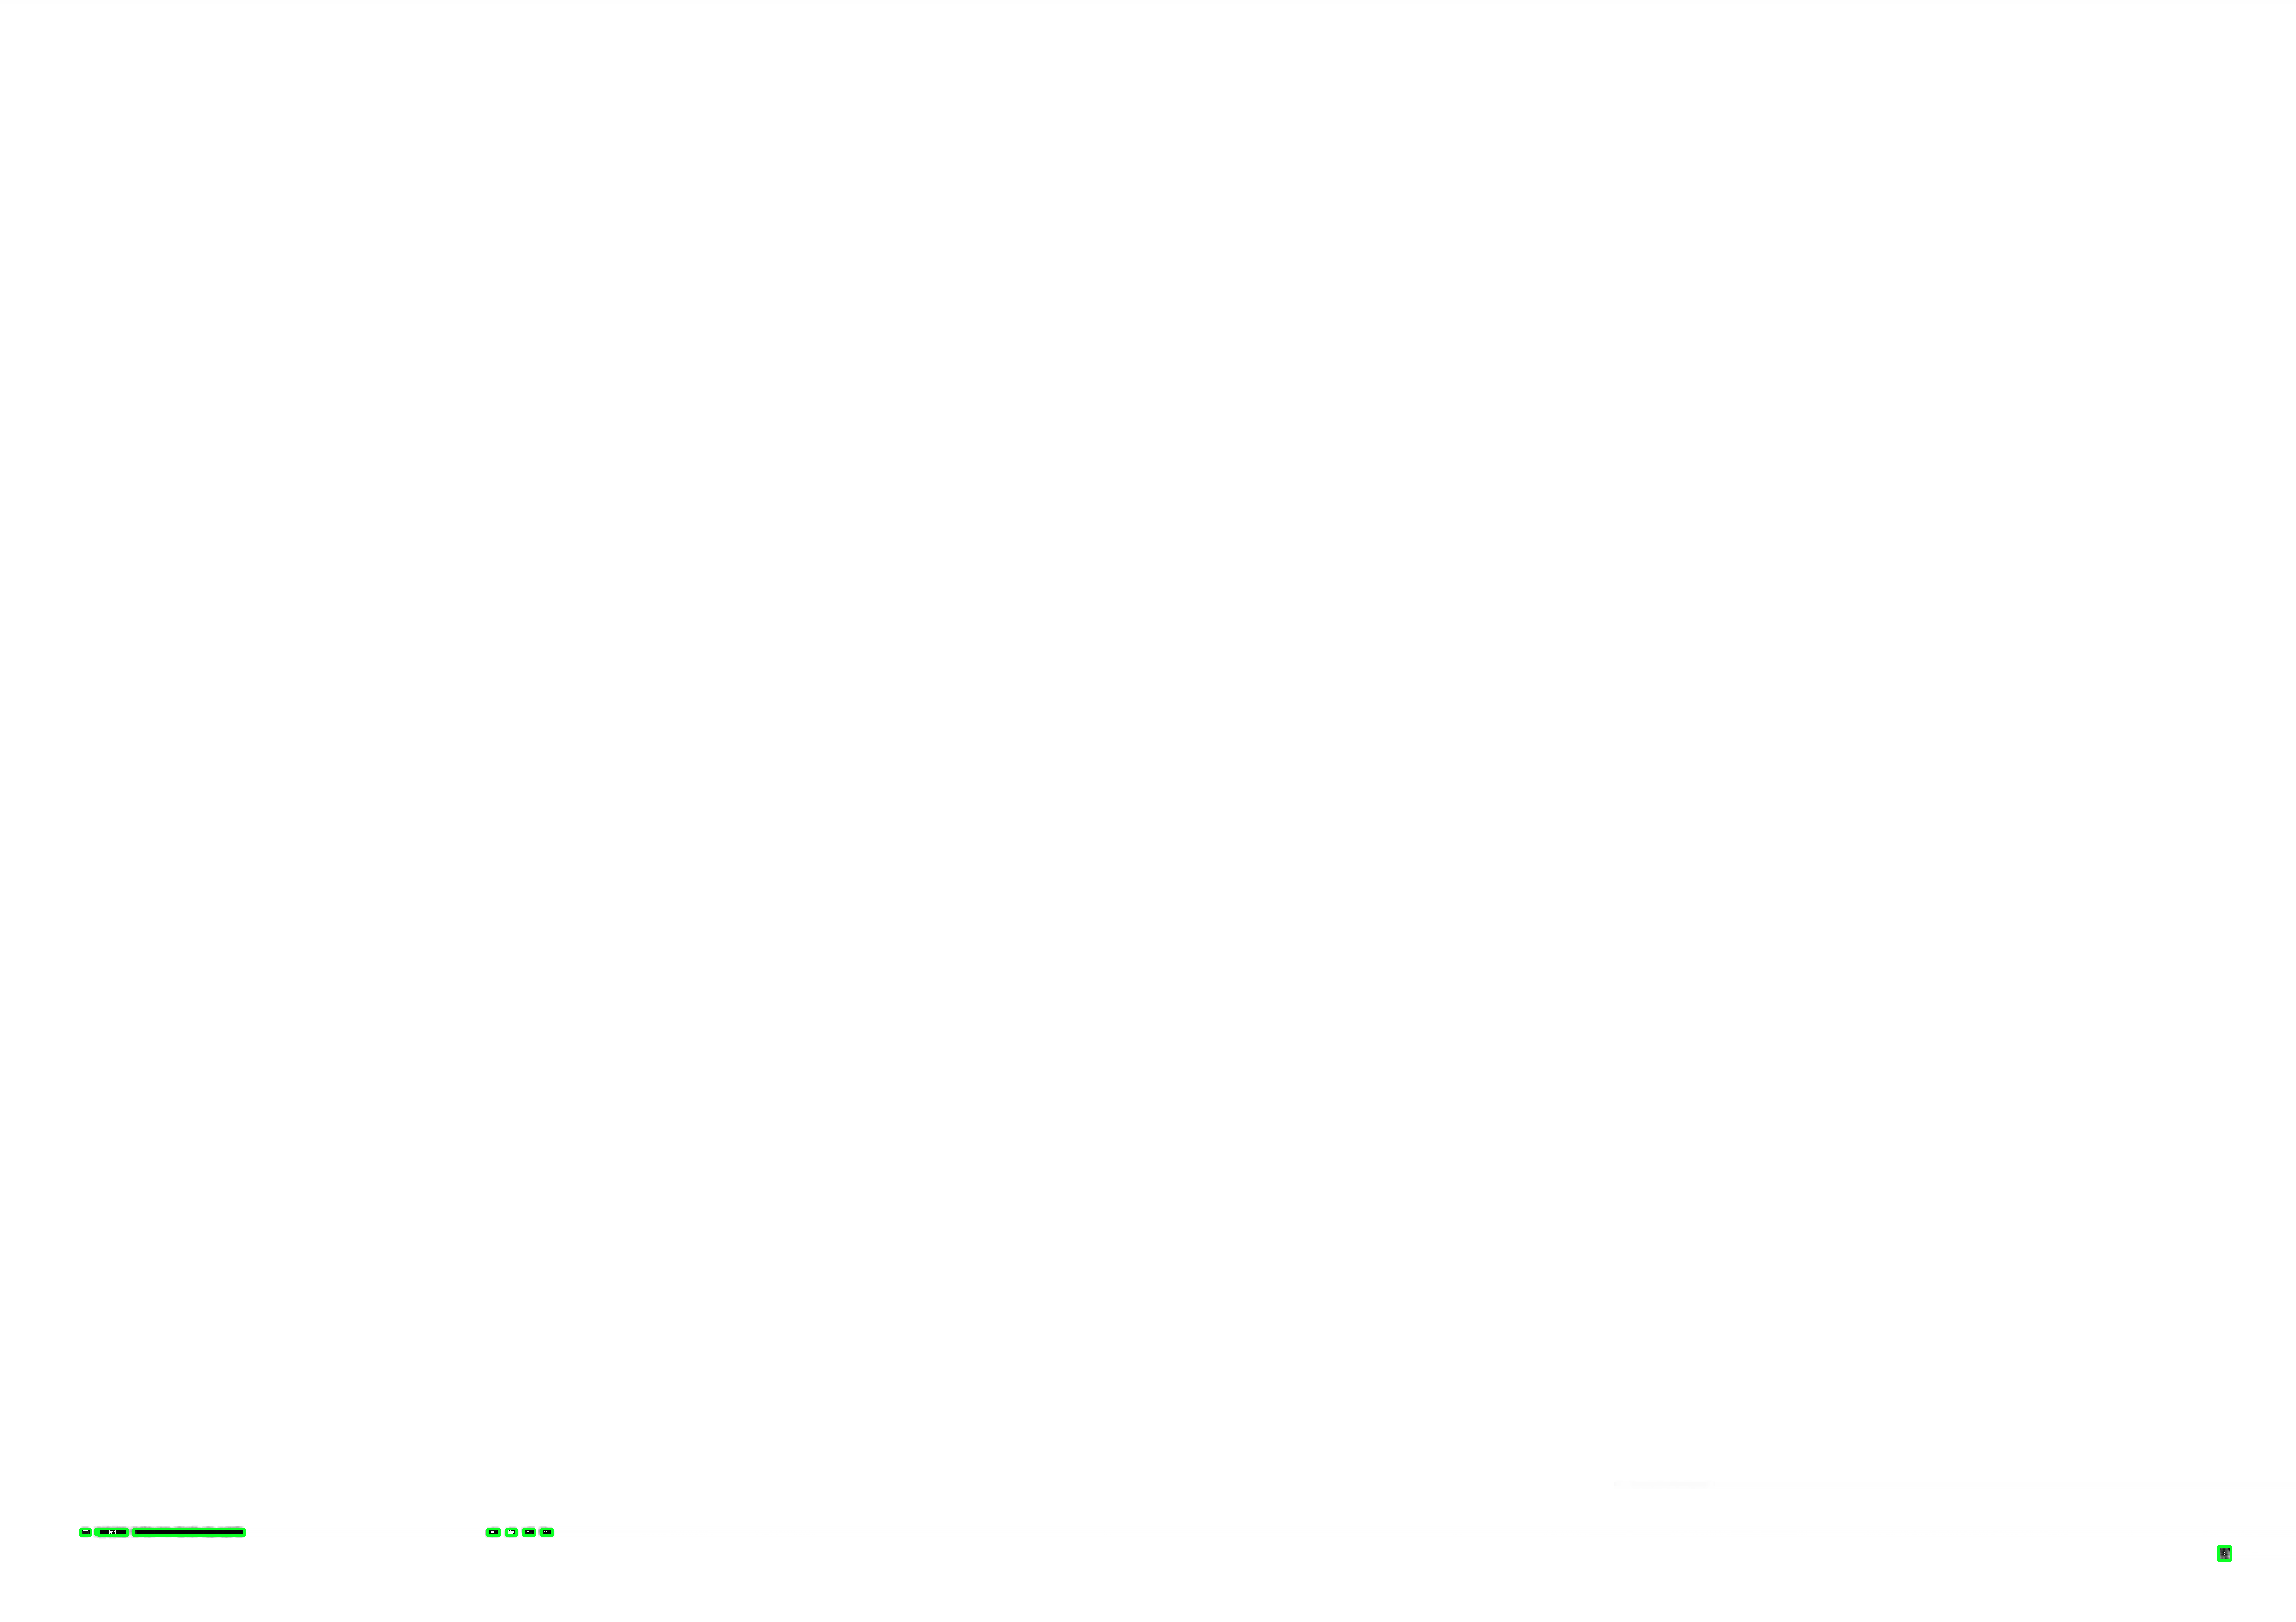

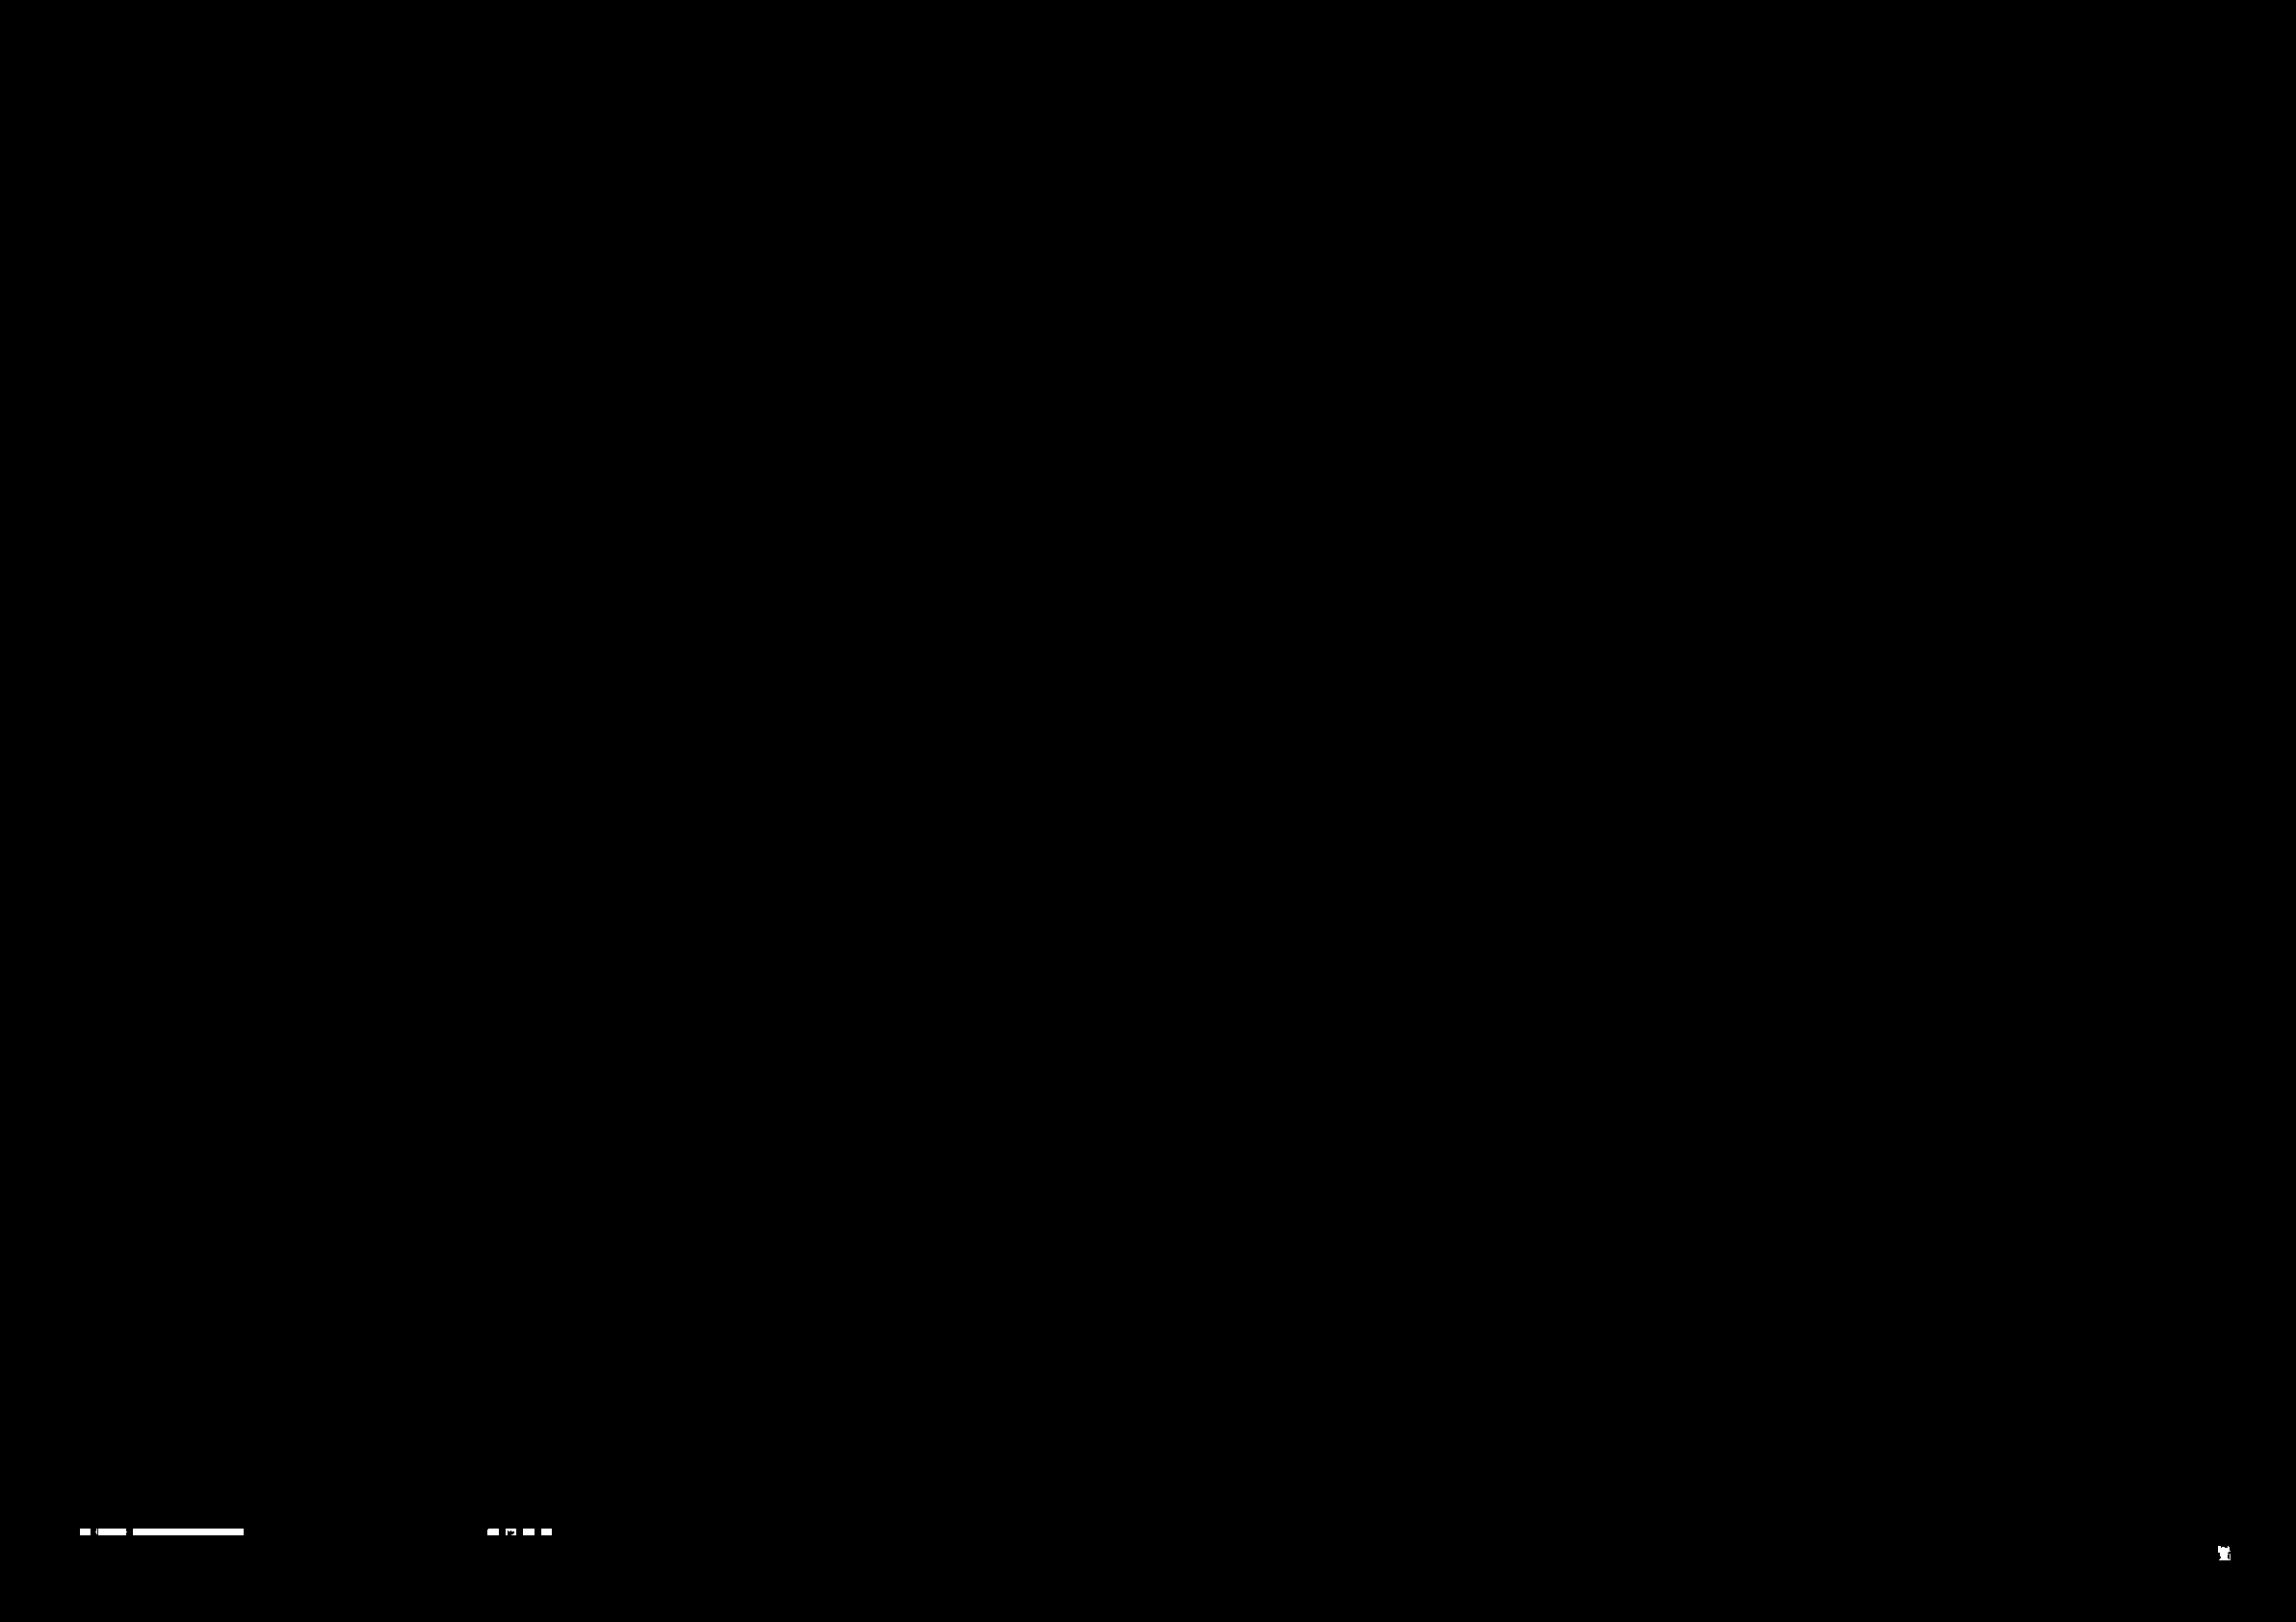

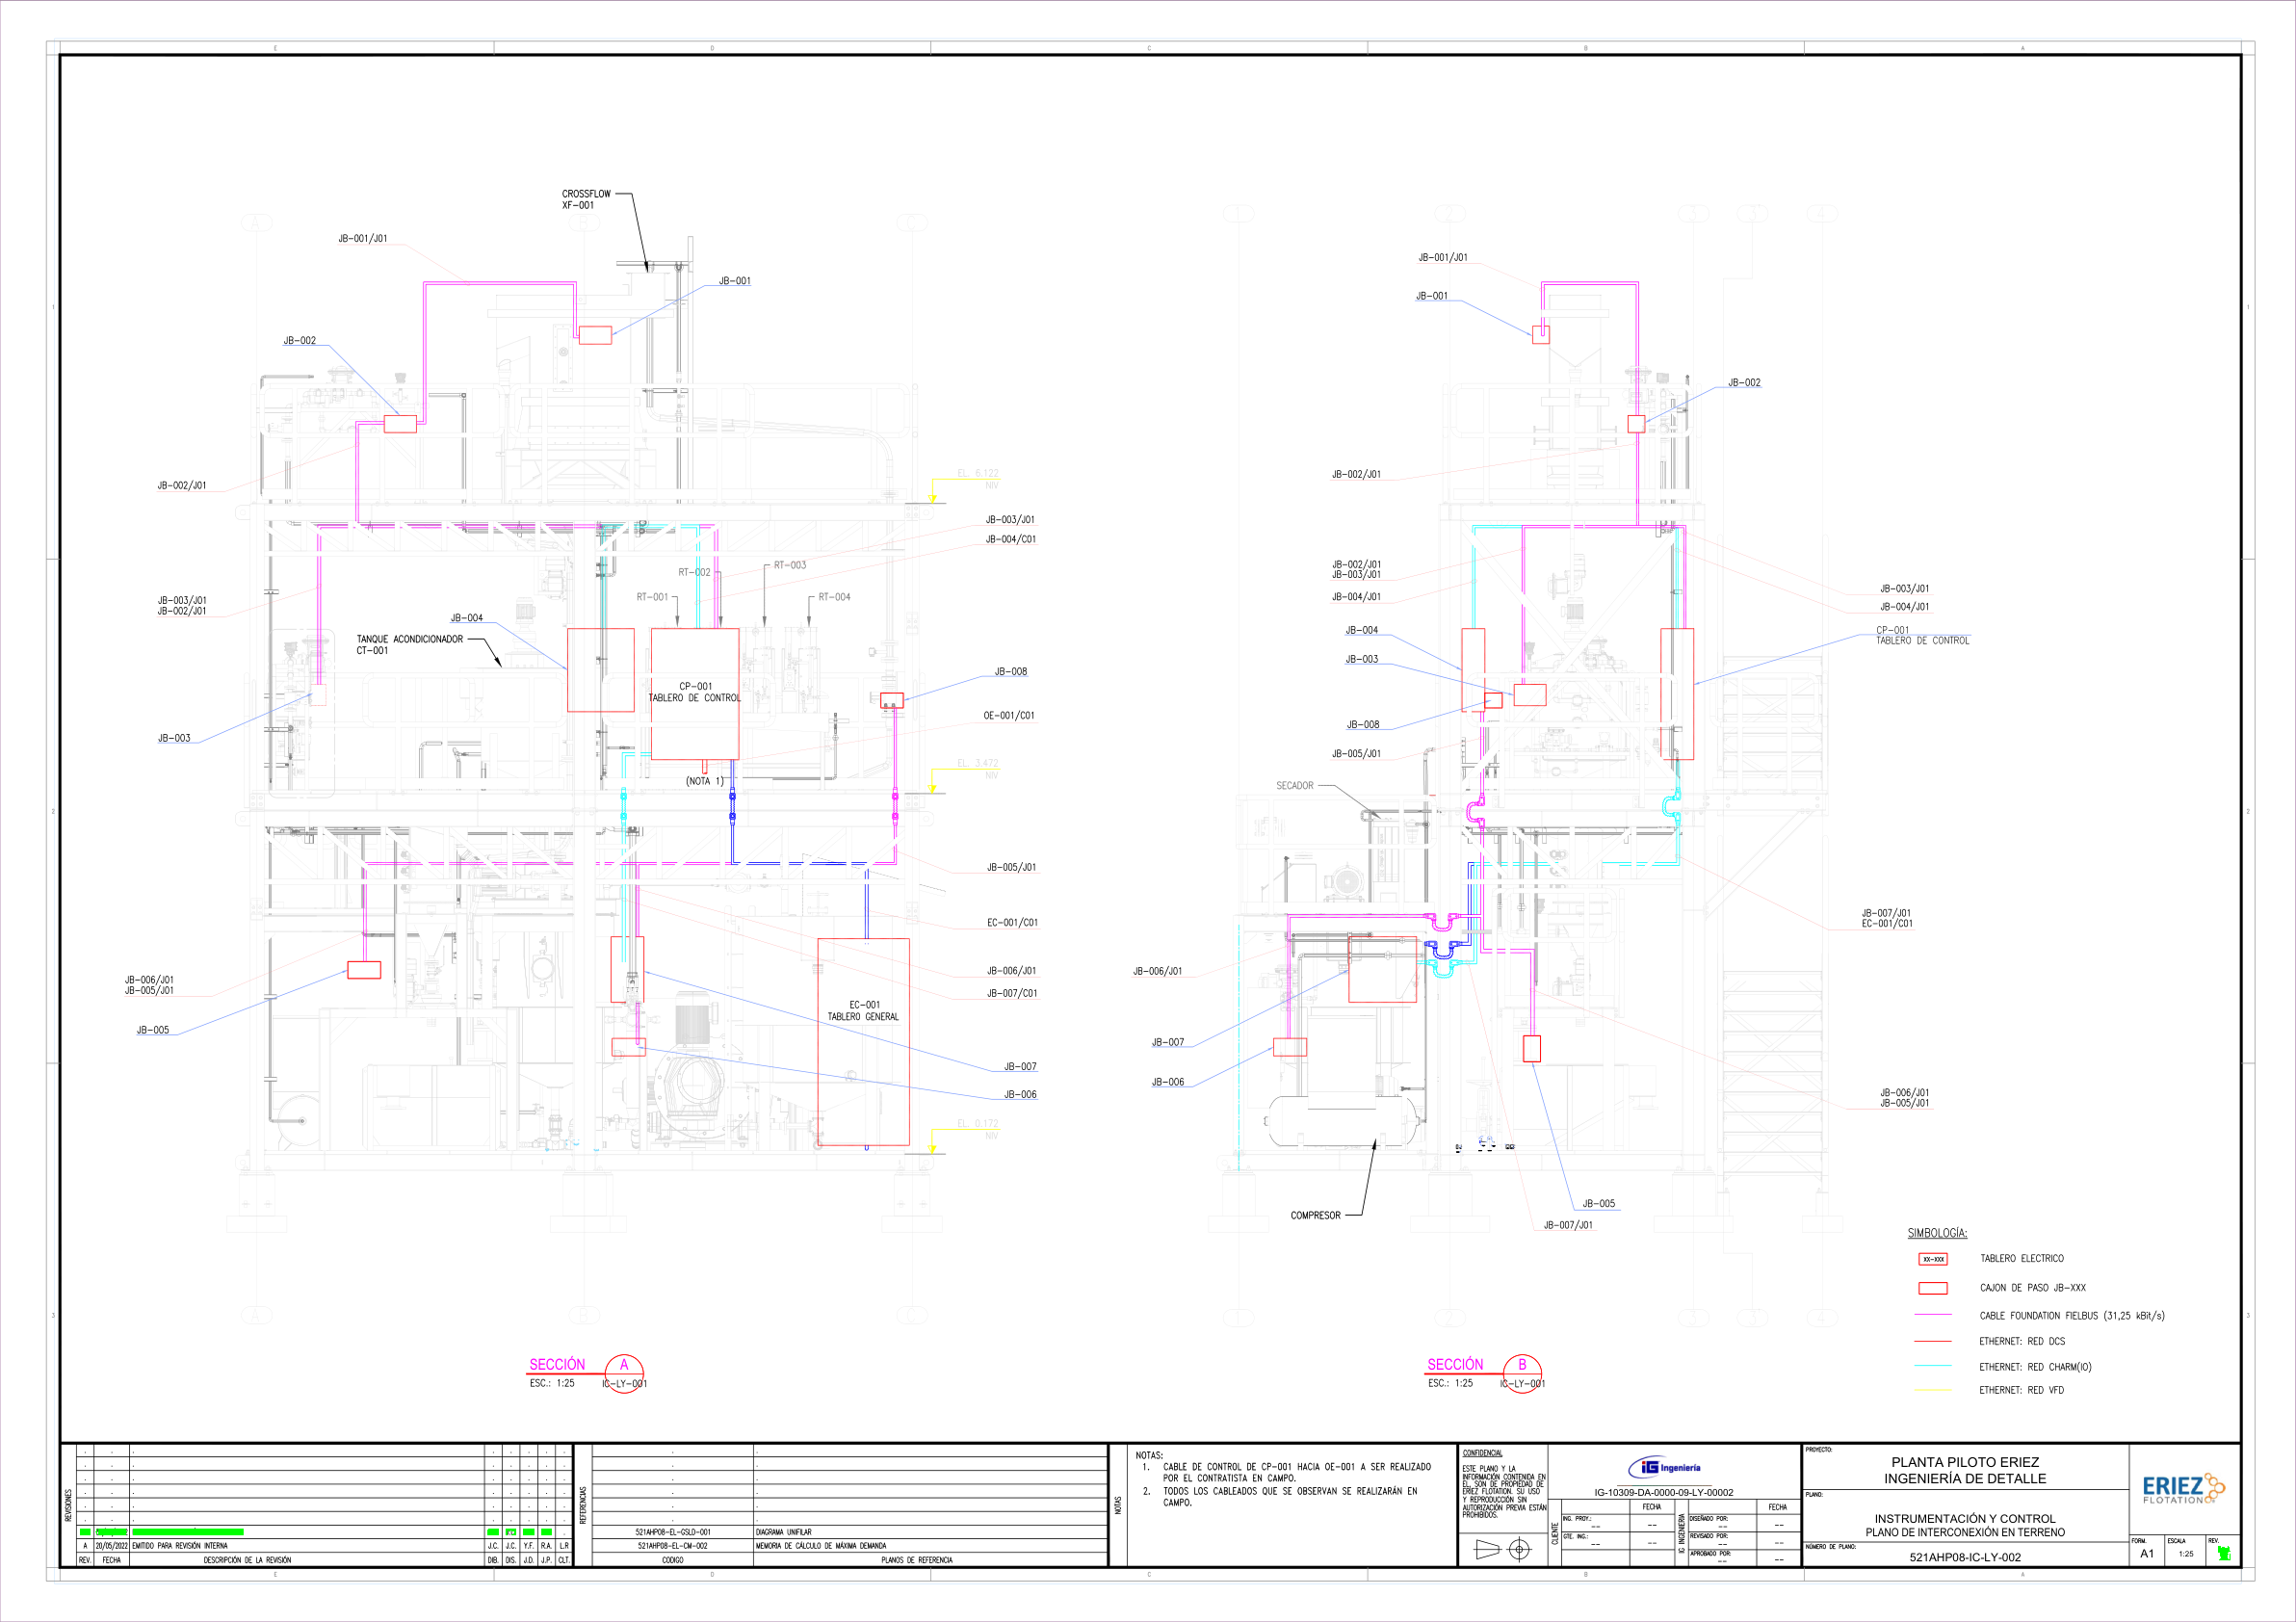

In [4]:
import csv
from skimage.metrics import structural_similarity
import cv2
import numpy as np

# Load images
before = cv2.imread('/content/im1_page_1.png')
after = cv2.imread('/content/im2_page_1.png')

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between the two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1]
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")
diff_box = cv2.merge([diff, diff, diff])

# Adjust the threshold to highlight more noticeable changes
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(before.shape, dtype='uint8')
filled_after = after.copy()

# List to store bounding boxes
bounding_boxes = []

for c in contours:
    area = cv2.contourArea(c)
    if area > 0:  # Adjust the area threshold as needed
        x, y, w, h = cv2.boundingRect(c)

        # Save bounding box coordinates
        bounding_boxes.append([x, y, x + w, y + h])

        cv2.rectangle(before, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.drawContours(mask, [c], 0, (255, 255, 255), -1)
        cv2.drawContours(filled_after, [c], 0, (0, 255, 0), -1)

# Save bounding box coordinates to CSV with x1, y1, x2, y2 columns
csv_path = '/content/bounding_boxes.csv'
with open(csv_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['x1', 'y1', 'x2', 'y2'])
    csv_writer.writerows(bounding_boxes)

cv2_imshow(before)
cv2_imshow(after)
cv2_imshow(diff)
cv2_imshow(diff_box)
cv2_imshow(mask)
cv2_imshow(filled_after)


In [5]:
import fitz  # PyMuPDF
import os
from PIL import Image, ImageSequence  # Import Image and ImageSequence

def convert_pdfs_to_gif_and_save_images(pdf_paths, output_path):
    gif_frames = []

    for idx, pdf_path in enumerate(pdf_paths, start=1):
        # Open the PDF file
        pdf_document = fitz.open(pdf_path)

        # Create a subfolder for each PDF
        #pdf_subfolder = os.path.join(output_path, f"pdf_{idx}")
        #os.makedirs(pdf_subfolder, exist_ok=True)

        # Iterate through each page
        for page_number in range(pdf_document.page_count):
            # Get the page
            page = pdf_document[page_number]

            # Convert the page to a pixmap
            pixmap = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))  # Set the resolution to 300 DPI

            # Convert the pixmap to a PIL Image
            image = Image.frombytes("RGB", [pixmap.width, pixmap.height], pixmap.samples)

            # Append the image to the list of frames
            gif_frames.append(image)

            # Save the individual image with the appropriate name
            #image.save(os.path.join(pdf_subfolder, f"im{idx}_page_{page_number + 1}.png"))

        # Close the PDF file
        pdf_document.close()

    # Save the frames as a GIF
    gif_frames[0].save(os.path.join(output_path, "output.gif"), save_all=True, append_images=gif_frames[1:], duration=250, loop=0)

# Example usage with two PDFs
pdf_file_paths
output_folder_path = '/content'

convert_pdfs_to_gif_and_save_images(pdf_file_paths, output_folder_path)


In [6]:
import fitz  # PyMuPDF
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageSequence  # Import Image, ImageDraw, and ImageSequence

def load_bounding_boxes(csv_path):
    # Load bounding boxes from CSV
    return pd.read_csv(csv_path)

def draw_bounding_boxes(image, bounding_boxes, scale_factor):
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(image)
    for _, box in bounding_boxes.iterrows():
        # Extract bounding box coordinates
        x1, y1, x2, y2 = box[['x1', 'y1', 'x2', 'y2']]

        # Scale bounding box coordinates
        scaled_x1 = int(x1 * scale_factor)
        scaled_y1 = int(y1 * scale_factor)
        scaled_x2 = int(x2 * scale_factor)
        scaled_y2 = int(y2 * scale_factor)

        # Draw rectangle using scaled coordinates
        draw.rectangle([scaled_x1, scaled_y1, scaled_x2, scaled_y2], outline="red", width=2)

def convert_pdfs_to_gif_and_save_images(pdf_paths, bounding_boxes_csv, output_path):
    gif_frames = []

    # Load bounding boxes
    bounding_boxes = load_bounding_boxes(bounding_boxes_csv)

    for idx, pdf_path in enumerate(pdf_paths, start=1):
        # Open the PDF file
        pdf_document = fitz.open(pdf_path)

        # Iterate through each page
        for page_number in range(pdf_document.page_count):
            # Get the page
            page = pdf_document[page_number]

            # Convert the page to a pixmap
            pixmap = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))  # Set the resolution to 300 DPI

            # Convert the pixmap to a PIL Image
            image = Image.frombytes("RGB", [pixmap.width, pixmap.height], pixmap.samples)

            # Draw bounding boxes on the image with correct scaling
            draw_bounding_boxes(image, bounding_boxes, 300/72)  # Pass the scale factor here

            # Append the image to the list of frames
            gif_frames.append(image)

        # Close the PDF file
        pdf_document.close()

    # Save the frames as a GIF
    gif_frames[0].save(os.path.join(output_path, "output_bboxes.gif"), save_all=True, append_images=gif_frames[1:], duration=250, loop=0)

# Example usage with two PDFs
bounding_boxes_csv = '/content/bounding_boxes.csv'
output_folder_path = '/content'

convert_pdfs_to_gif_and_save_images(pdf_file_paths, bounding_boxes_csv, output_folder_path)